# Titanic Kaggle Competition

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, chi2

## Raw Extraction

In [434]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [435]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data preprocessing

In [368]:
print('Instances = ' + str(train_data.shape[0]))
train_data.isna().sum()
test_data.isna().sum()

Instances = 891


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [436]:
test_data['Fare'] = test_data['Fare'].fillna(test_data.loc[test_data.Pclass == 3, 'Fare'].mean())

In [437]:
train_data.drop(['PassengerId', 'Cabin', 'Embarked', 'Age'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Cabin', 'Embarked', 'Age'], axis=1, inplace=True)

In [438]:
train_data.shape
test_data.shape

(418, 7)

In [ ]:
for idx, row in train_data.iterrows():
    name = row['Name']
    if 'Andersson,' in name:
        print(row)

## Feature Extraction

In [439]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

def get_family(row):
    surname = row['Name'].split(',')[0]
    
    if row['SibSp'] + row['Parch'] == 0:        
        ticket = row['Ticket']
        return str(surname + ' ' + ticket)
    else:
        return surname
    
def extract_features(df):    
    df['Family'] = df.apply(lambda x: get_family(x), axis=1)
    df['Title'] = df.apply(lambda x: x['Name'].split(',')[1].split('.')[0].strip(), axis=1)
    df['Solo_Traveler'] = df.apply(lambda x: int(x['SibSp'] + x['Parch'] == 0), axis=1)
    df['SexB'] = df.apply(lambda x: int(x['Sex'] == 'male'), axis=1)
    
    df['Title']=df.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
    df['Title']=df.Title.map(newtitles)
    
    return df

train_data = extract_features(train_data)
test_data = extract_features(test_data)

In [407]:
train_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Family', 'Title', 'Solo_Traveler', 'SexB'],
      dtype='object')

In [408]:
test_data.columns

Index(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Family',
       'Title', 'Solo_Traveler', 'SexB'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29def3d0>]],
      dtype=object)

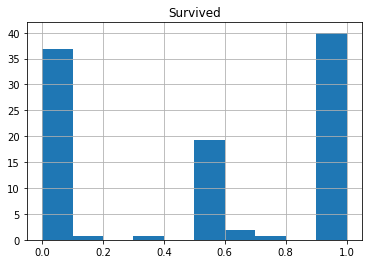

In [212]:
df = train_data[train_data.SibSp > 0].groupby(by=['Family']).mean()
df.hist(column='Survived', bins=10, weights=np.ones_like(df[df.columns[0]]) * 100. / len(df))

In [441]:
feature_columns = ['Pclass', 'SibSp', 'Parch', 'Solo_Traveler', 'SexB', 'Fare', 'Title']
df = train_data[['Survived'] + feature_columns]
df_test = test_data[feature_columns]

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

In [393]:
df_test.columns

Index(['Pclass', 'SibSp', 'Parch', 'Solo_Traveler', 'SexB', 'Fare'], dtype='object')

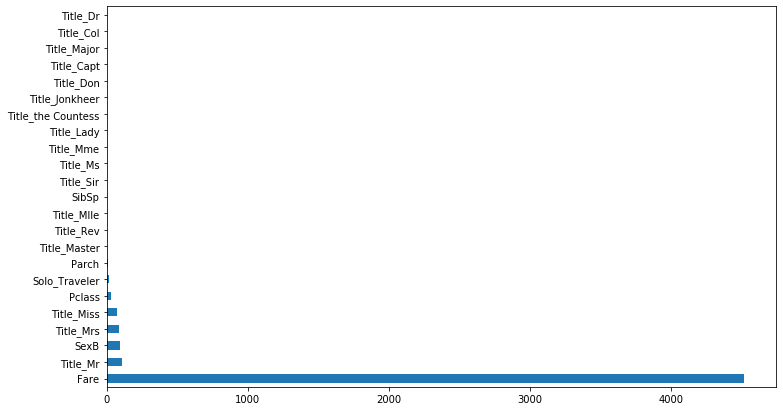

In [361]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
model = bestfeatures.fit(df.drop(['Survived'], axis=1).values, df['Survived'].values)
scores = model.scores_

fig, _ = plt.subplots(figsize=(12,7))
pd.Series(scores, index=df.drop(['Survived'], axis=1).columns).nlargest(30).plot(kind='barh')

## Modeling

In [444]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

x = df.drop(['Survived'], axis=1).values
y = df['Survived'].values

print('Random Forest Regressor')
pipeline = Pipeline([('kbest', SelectKBest(score_func=chi2, k=1)), 
                     ('random_forest', RandomForestClassifier(random_state=1))])
parameters = {'kbest__k': [4, 5, 6, 7, 8], 'random_forest__n_estimators': [25, 50, 75, 100]}
cv = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=10).fit(x, y)
print("Accuracy: %0.2f" % (cv.best_score_))
print(f'Best params: {cv.best_params_}')

#print()

print('SVM RBF')
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('svm_rbf', SVC(kernel='rbf'))])
parameters = {'svm_rbf__C': [0.0001,0.001,0.1,1,10], 'svm_rbf__gamma': [0.0001,0.001,0.1,1,10]}
cv = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=10).fit(x, y)
print("Accuracy: %0.2f" % (cv.best_score_))
print(f'Best params: {cv.best_params_}')

Random Forest Regressor
Accuracy: 0.82
Best params: {'kbest__k': 6, 'random_forest__n_estimators': 25}
SVM RBF
Accuracy: 0.82
Best params: {'svm_rbf__C': 1, 'svm_rbf__gamma': 0.1}


In [446]:
predictions = cv.predict(df_test.values)

output = pd.DataFrame({'PassengerId': pd.read_csv("data/test.csv").PassengerId, 'Survived': predictions})
output.to_csv('data/my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
